In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits

In [137]:
#hdu = fits.open('SALT/TOI237/mbgphR201908090023_u1we.fits')
hdu = fits.open('SALT/TOI122/mbgphR201908090019_u1we.fits')
flux = hdu[14].data
w0 = np.float(hdu[14].header['CRVAL1'])
dw = np.float(hdu[14].header['CDELT1'])
wave = np.arange(flux.size)*dw+w0

In [123]:
wave[2500]

6591.78249135

In [126]:
np.mean(flux[1300:2500])

3.3980647e-05

In [130]:
EW = np.sum(1-(flux[1733:1920]/3.846e-5)*dw)
print(EW)

177.00208


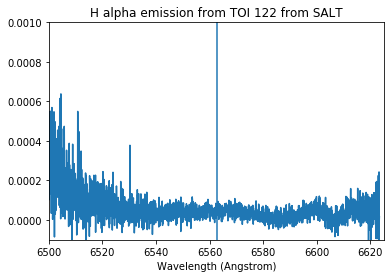

In [113]:
plt.plot(wave,flux)
plt.axvline(6562.801)
#plt.xlim(6561.5,6563.5)
plt.xlim(6500,6625)
plt.ylim(-0.0001,0.001)
plt.title('H alpha emission from TOI 122 from SALT')
plt.xlabel('Wavelength (Angstrom)')
plt.savefig('TOI_122_Halpha.pdf')

In [134]:
# sum up over a region, with fractions of a pixel
# wavea = blue edge; waveb = red edge
# c1 and c2 are the edges of the region of interest
# mean returns the average of the pixels rather than the sum
# check makes plots

def fracsum(wavea, waveb, flux, c1, c2, mean=False, check=False):
  
    pixwidth = waveb-wavea  
    fracused = np.zeros_like(flux)
  
    # make sure wide enough
    if (wavea[0]>=c1) or (waveb[-1]<=c2):
      return None
    
    # whole pixels
    wholeind, = np.where( (wavea>=c1) & (waveb<=c2) )
    if len(wholeind) == 0:
      print("WARNING fracsum: no whole pixels")
    fracused[wholeind] = 1.
    
    # partial pixels
    lowind, = np.where( (wavea<c1) & (waveb>c1) )
    uppind, = np.where( (wavea<c2) & (waveb>c2) )
    assert(len(lowind) <= 1)
    assert(len(uppind) <= 1)

    if (len(lowind) == 1) and (not (lowind in wholeind)):
      fracused[lowind] = (waveb[lowind]-c1)/pixwidth[lowind]
    if (len(uppind) == 1) and (not np.any(uppind in wholeind)):
      fracused[uppind] = (c2-wavea[uppind])/pixwidth[uppind]

    if check:
      plt.scatter(wavea, flux)
      plt.scatter(waveb, flux)
      plt.plot([c1,c1],[0,10])
      plt.plot([c2,c2],[0,10])
      print(np.arange(0,len(flux)))
      print(fracused)
      print(flux)
    
    integral = np.sum(flux*fracused*pixwidth)
    if mean:
      return integral/np.sum(fracused*pixwidth)
    else:
      return integral
    
# assume pixel edges are half-way between the central locations
def simple_fracsum(wave, flux, c1, c2, mean=False):
  
    diff = np.array(wave.flat[1:] - wave.flat[:-1])
    pixwidth = np.concatenate(([diff[0]], (diff[1:]+diff[:-1])/2., [diff[-1]]))

    wavea = wave-pixwidth/2.
    waveb = wave+pixwidth/2.
   
    return fracsum(wavea, waveb, flux, c1, c2, mean=mean)

# check something simple
def test():

    wavea=np.arange(0,10)
    waveb=wavea+1.
    flux=np.ones_like(wavea)*2.
    flux[3:7]=4.
    c1 = 4.5
    c2=8.
    plt.clf()
    v1 = fracsum(wavea, waveb, flux, c1, c2, check=True)

    wave=np.arange(0,10)+0.5
    v2 = simple_fracsum(wave,flux, c1, c2)
    
    assert(v1 == v2)
    assert(v1 == 12.)
  
  
# Lithium index
def measure_li(wave, flux):

    fcen = 6707.8 # 6707.76; 6707.91
    # note iron at 6707.4
    fwid = 2.
    feature = [fcen-fwid/2.,fcen+fwid/2.]

    feat = simple_fracsum(wave, flux, feature[0], feature[1], mean=True)

    cont = simple_fracsum(wave, flux, 6710., 6712., mean=True)
    
    return feat/cont


# H alpha EW     
def measure_ha(wave, flux, trapsum=False):
    
    # feature region
    fcen = 6562.8
    fwid = 8.
    feature = [fcen-fwid/2.,fcen+fwid/2.]
    
    m1 = simple_fracsum(wave, flux, 6500., 6550., mean=True)
    m2 = simple_fracsum(wave, flux, 6575., 6623., mean=True)
    pseudo = (m1+m2)/2.

    ew = simple_fracsum(wave, 1.-flux/pseudo, feature[0], feature[1])
    return ew

In [138]:
ew = measure_ha(wave,flux)

In [139]:
print(ew)

0.08520776599926046
